# Лабораторная работа 2
## Деревья

Попробуем реализовать деревянные модели и применить их к набору данных, рассматренному в нулевой работе.

Напомню, что мы решаем задачу выявления пациентов с высоким риском сердечного приступа.

### Подготовка данных

In [71]:
import pandas as pd
import pickle
import random

In [2]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [3]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
numerical_features = ['MentHlth', 'PhysHlth', 'BMI']
target = 'HeartDiseaseorAttack'
categorical_features = [feat for feat in list(df.columns) if feat != target and feat not in numerical_features]

Пайплайн обработки данных тот же.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin

In [6]:
data_preprocessing = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), categorical_features),
    ('stdscale', StandardScaler(), ['BMI']),
    ('minmax', MinMaxScaler(), [feat for feat in numerical_features if feat != 'BMI'])
])

In [7]:
class ToArrayTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

Делим на трейн и тест.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop(target, axis=1)
y = df[target]
assert len(X) == len(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0xDEAD)

In [11]:
X_train.shape, X_test.shape

((202944, 21), (50736, 21))

## Подсчет метрик

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

In [13]:
def get_metrics(model, X, y_true, threshold=0.5, use_probas=True):
    
    if use_probas:
        y_pred_probas = model.predict_proba(X)
        if len(y_pred_probas.shape) == 2:
            y_pred_probas = y_pred_probas[:, 1] 
        y_pred = y_pred_probas > threshold
    else:
        y_pred = model.predict(X)
    
    print('Accuracy = ', accuracy_score(y_true, y_pred))
    print('Precision = ', precision_score(y_true, y_pred))
    print('Recall = ', recall_score(y_true, y_pred))
    if use_probas:
        print('ROC AUC = ', roc_auc_score(y_true, y_pred_probas))
    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))
    
    if use_probas:
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probas)
        plt.figure(figsize=(15, 8))
        plt.xlabel('Recall')
        plt.ylabel('Presicion')
        plt.title('Precision-recall curve')
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.grid()
        plt.plot(recall, precision)

Помним про то, что у нас очень несбалансированные классы (91% vs 9%). Поэтому трешхолд 0.5 не всегда будет оптимален для нашей задачи. Поэтому будем строить дополнительно precison-recall кривую, чтобы оценить зависимость пресижена от реколла.

Также учитываем, что в этой задаче нам важно не упустить больных пациентов, поэтому будем стремиться максимизировать реколл.

Установим отметку реколла = 0.7 и будем сравнивать модели при таком реколле.

## Decision tree

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

Сначала опишем вспомогательный класс для вершины дерева

In [123]:
class Node:
    def __init__(self, probability):
        self.probability = probability # вероятность единички при попадании в эту вершину
        self.feature_index = 0  # по какой фиче разбиваем
        self.threshold = 0  # по какому порогу фичи разбиваем
        self.left = None  # левое поддерево
        self.right = None  # правое поддерево

In [151]:
class MyDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
    
    def fit(self, X, y, random_features=False):
        X, y = check_X_y(X, y)
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        # self.weights = np.array([np.sum(y == i) for i in range(1, -1, -1)]) / len(y)
        self.weights = np.array([10, 1])
        self.tree = self._build_tree(X, y, random_features)
    
    def _build_tree(self, X, y, depth=0, random_features=False):
        num_samples_per_class = [np.sum(y == i) for i in range(2)]
        proba = num_samples_per_class[1] / sum(num_samples_per_class)
        node = Node(probability=proba)
        if depth < self.max_depth:
            feature_id, threshold = self._get_best_split(X, y, random_features) # ищем лучший сплит
            if feature_id is not None:
                # None может быть только если мы в листе
                indices_left = X[:, feature_id] < threshold
                indices_right = X[:, feature_id] >= threshold
                X_left, y_left = X[indices_left], y[indices_left] # в одну сторону идет все что меньше порога
                X_right, y_right = X[indices_right], y[indices_right] # в другую сторону все остальное
                node.feature_index = feature_id
                node.threshold = threshold
                node.left = self._build_tree(X_left, y_left, depth + 1) # рекурсивно строим дерево дальше
                node.right = self._build_tree(X_right, y_right, depth + 1)
        return node
    
    def _get_best_split(self, X, y, random_features=False):
        m = y.size
        if m <= 1:
            # в вершине остались только элементы одного класса -> это лист
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes)]
        best_gini = 1.0 - sum((self.weights[i] * num_parent[i] / m) ** 2 for i in range(self.n_classes))
        best_feature_id, best_threshold = None, None
        
        features = list(range(self.n_features))
        if random_features is True:
            features = np.array(random.shuffle(features))
            feat_num = int(np.ceil(np.sqrt(self.n_features)))
            features = np.resize(features, feat_num)

        for feature_id in features:
            # смотрим каждую фичу
            thresholds, classes = zip(*sorted(zip(X[:, feature_id], y)))
            num_left = [0] * self.n_classes
            num_right = num_parent.copy()
            for i in range(1, m):
                if thresholds[i] == thresholds[i - 1]:
                    continue
                
                # смотрим все возможные разбиения и ищем лучшее по критерию Джини
                c = int(classes[i - 1])
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((self.weights[x] * num_left[x] / i) ** 2 for x in range(self.n_classes))
                gini_right = 1.0 - sum((self.weights[x] * num_right[x] / (m - i)) ** 2 for x in range(self.n_classes))
                gini = (i * gini_left + (m - i) * gini_right) / m
                
                if gini < best_gini:
                    best_gini = gini
                    best_feature_id = feature_id
                    best_threshold = (thresholds[i] + thresholds[i-1]) / 2
        return best_feature_id, best_threshold
    
    def predict(self, X, threshold=0.5):
        return np.array(self.predict_proba(X)) > threshold
    
    def predict_proba(self, X):
        X = check_array(X)
        res = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            node = self.tree
            while node.left:
                if X[i][node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            res[i] = node.probability
        return res

In [155]:
dt_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('decision_tree', MyDecisionTree(max_depth=10))
    ]
)

In [156]:
dt_my.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke', 'Diabetes',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'GenHlth',
                                                   'DiffWalk', 'Sex', 'Age',
                                                   'Education', 'Income']),
                                                 ('stdscale', StandardScaler(),
                 

In [45]:
dt_my_gs = GridSearchCV(dt_my, {'decision_tree__max_depth': [1, 3, 5, 7]})
dt_my_gs.fit(X_train, y_train);

In [46]:
dt_my_gs.best_params_

{'decision_tree__max_depth': 5}

Accuracy =  0.9043479974771366
Precision =  0.0
Recall =  0.0
ROC AUC =  0.5001149592541569
Confusion matrix:
[[45883     0]
 [ 4853     0]]


C:\Users\moise\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


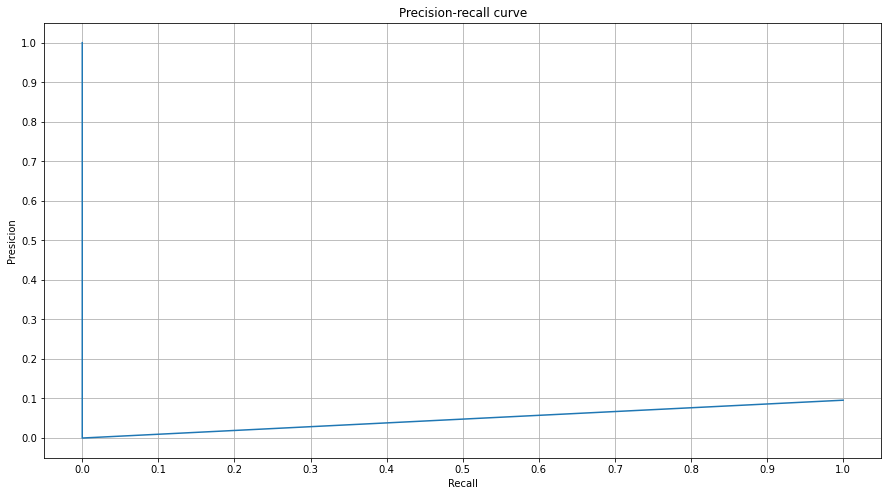

In [157]:
get_metrics(dt_my, X_test, y_test, threshold=0.85)

Из-за несбалансированности классов дерево не смогло обнаружить единички - нужно добавлять веса к классам

*но времени не хватает на это :(*

In [48]:
f = open("tree.pkl", "wb")
pickle.dump(dt_my_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

Sklearn:

In [51]:
from sklearn.tree import DecisionTreeClassifier

dt_sk = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('decision_tree', DecisionTreeClassifier(class_weight='balanced'))
    ]
)

In [52]:
dt_sk_gs = GridSearchCV(dt_sk, {'decision_tree__criterion': ['gini', 'entropy'],
                               'decision_tree__max_depth': [1, 3, 5, 7],
                               'decision_tree__min_samples_split': [2, 3, 4],
                               'decision_tree__min_samples_leaf': [1, 2, 3]})
dt_sk_gs.fit(X_train, y_train);

In [53]:
dt_sk_gs.best_params_

{'decision_tree__criterion': 'gini',
 'decision_tree__max_depth': 5,
 'decision_tree__min_samples_leaf': 1,
 'decision_tree__min_samples_split': 2}

Accuracy =  0.7291666666666666
Precision =  0.22225
Recall =  0.7327426334226251
ROC AUC =  0.7919516365097423
Confusion matrix:
[[33439 12444]
 [ 1297  3556]]


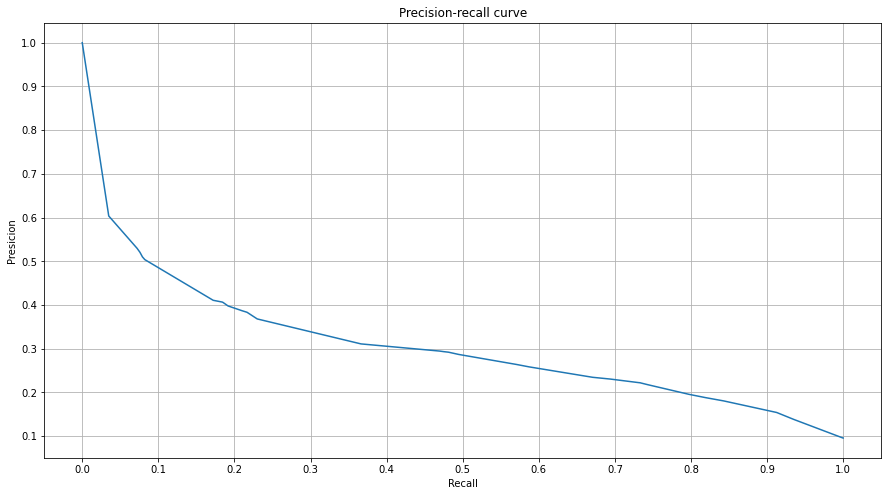

In [65]:
get_metrics(dt_sk_gs, X_test, y_test, threshold=0.55)

In [55]:
f = open("tree_sklearn.pkl", "wb")
pickle.dump(dt_sk_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Random Forest

In [114]:
class MyRandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.trees = []
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        for i in range(self.n_estimators):
            tree = MyDecisionTree()
            X_sample, y_sample = self._data_bagging(X, y)
            tree.fit(X_sample, y_sample, random_features=True)
            self.trees.append(tree)
    
    def _data_bagging(self, X,y):
        x_size = len(X)
        x_sample = []
        y_sample = []
        while len(x_sample) < x_size:
            ind = random.randrange(x_size)
            x_sample.append(X[ind])
            y_sample.append(y[ind])
        x_sample = np.array(x_sample)
        y_sample = np.array(y_sample)
        return x_sample, y_sample
    
    def predict(self, X, threshold=0.5):
        return np.array(self.predict_proba(X)) > threshold
    
    def predict_proba(self, X):
        X = check_array(X)
        res = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            for tree in self.trees:
                node = tree.tree
                while node.left:
                    if X[i][node.feature_index] < node.threshold:
                        node = node.left
                    else:
                        node = node.right
                res[i] += node.probability
        return res / len(self.trees)

In [119]:
rf_my = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('random_forest', MyRandomForest(n_estimators=5))
    ]
)

In [120]:
rf_my.fit(X_train, y_train);

Accuracy =  0.9043479974771366
Precision =  0.0
Recall =  0.0
ROC AUC =  0.5003535542715349
Confusion matrix:


C:\Users\moise\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[45883     0]
 [ 4853     0]]


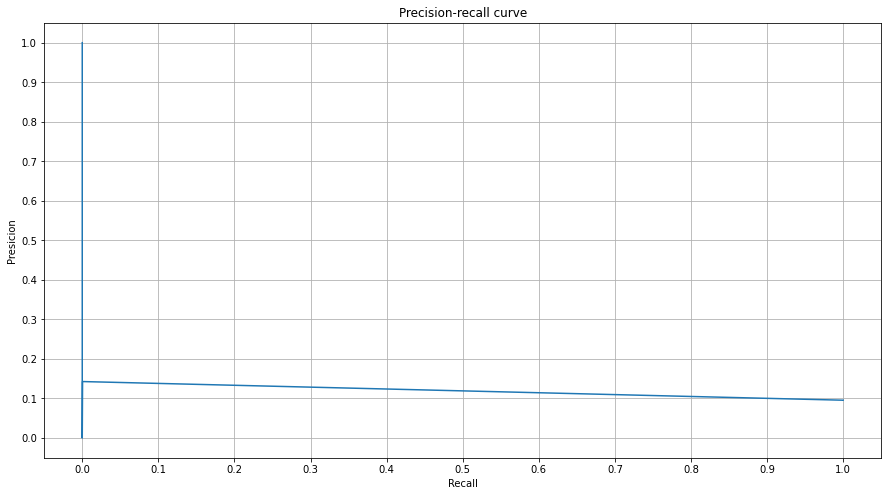

In [121]:
get_metrics(rf_my, X_test, y_test, threshold=0.55)

In [122]:
f = open("random_forest.pkl", "wb")
pickle.dump(rf_my, f, pickle.HIGHEST_PROTOCOL)
f.close()

Sklearn:

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf_sk = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('to_array', ToArrayTransformer()),
        ('random_forest', RandomForestClassifier(class_weight='balanced'))
    ]
)

In [78]:
rf_sk_gs = GridSearchCV(rf_sk, {'random_forest__n_estimators': [50, 100, 200]})
rf_sk_gs.fit(X_train, y_train);

In [79]:
rf_sk_gs.best_params_

{'random_forest__n_estimators': 200}

Accuracy =  0.9001695048880479
Precision =  0.38402625820568925
Recall =  0.07232639604368432
ROC AUC =  0.8139582701859442
Confusion matrix:
[[45320   563]
 [ 4502   351]]


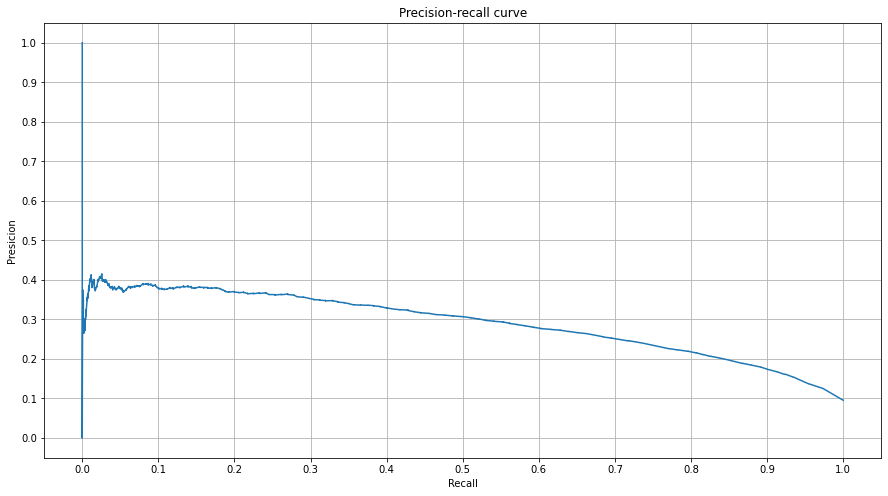

In [80]:
get_metrics(rf_sk_gs, X_test, y_test, threshold=0.55)

In [81]:
f = open("random_forest_sklearn.pkl", "wb")
pickle.dump(rf_sk_gs, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Градиентный бустинг

Воспользуемся библиотекой Catboost

In [108]:
import catboost

In [109]:
X_train_cb, y_train_cb = check_X_y(X_train, y_train)
X_test_cb, y_test_cb = check_X_y(X_test, y_test)
eval_dataset = catboost.Pool(data=X_test, label=y_test)

In [110]:
cb = catboost.CatBoostClassifier(iterations=2000,
                        learning_rate=0.05,
                        loss_function='Logloss',
                        auto_class_weights='Balanced',
                        use_best_model=True,
                        verbose=50)

In [111]:
cb.fit(X_train_cb, y_train_cb, eval_set=eval_dataset)

0:	learn: 0.6734310	test: 0.6733318	best: 0.6733318 (0)	total: 75.6ms	remaining: 2m 31s
50:	learn: 0.4825060	test: 0.4818779	best: 0.4818779 (50)	total: 3.06s	remaining: 1m 56s
100:	learn: 0.4741846	test: 0.4746807	best: 0.4746807 (100)	total: 6.03s	remaining: 1m 53s
150:	learn: 0.4712003	test: 0.4735159	best: 0.4735156 (149)	total: 8.82s	remaining: 1m 48s
200:	learn: 0.4691841	test: 0.4733569	best: 0.4733393 (171)	total: 11.8s	remaining: 1m 45s
250:	learn: 0.4669880	test: 0.4732337	best: 0.4730735 (238)	total: 14.8s	remaining: 1m 42s
300:	learn: 0.4644620	test: 0.4732802	best: 0.4730735 (238)	total: 17.6s	remaining: 1m 39s
350:	learn: 0.4623253	test: 0.4735863	best: 0.4730735 (238)	total: 21.1s	remaining: 1m 38s
400:	learn: 0.4602719	test: 0.4739562	best: 0.4730735 (238)	total: 24.1s	remaining: 1m 36s
450:	learn: 0.4583752	test: 0.4744086	best: 0.4730735 (238)	total: 27s	remaining: 1m 32s
500:	learn: 0.4565698	test: 0.4749440	best: 0.4730735 (238)	total: 29.8s	remaining: 1m 29s
550:	l

Accuracy =  0.7990184484389783
Precision =  0.28322245659581374
Recall =  0.7193488563774985
ROC AUC =  0.8520637375457684
Confusion matrix:
[[37048  8835]
 [ 1362  3491]]


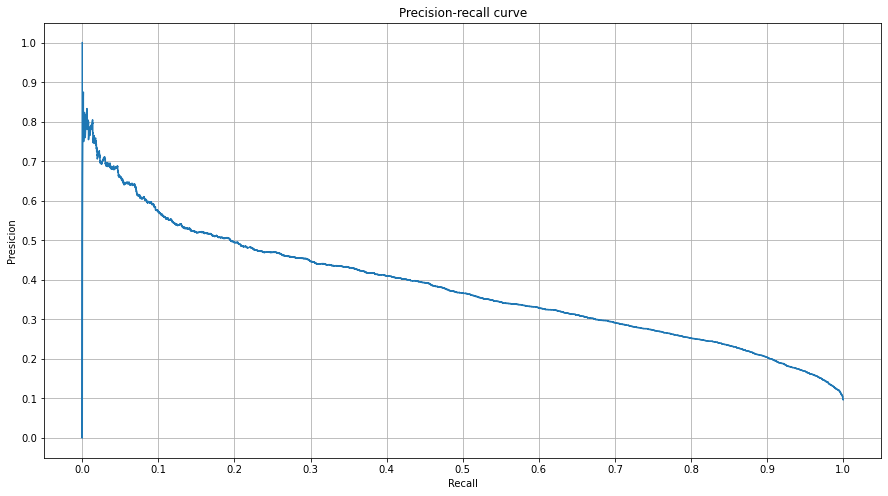

In [118]:
get_metrics(cb, X_test_cb, y_test_cb, threshold=0.6)

С помощью катбуста мы получили один из наиболее хороших результатов - при реколле 0.7 имеем точность почти 0.3. При остальных реколлах точность тоже самая высокая (прошлый лидер - регрессия).

In [113]:
f = open("catboost.pkl", "wb")
pickle.dump(cb, f, pickle.HIGHEST_PROTOCOL)
f.close()